# Chest X-Ray Medical Diagnosis with Deep Learning

<img src="xray-header-image.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">

Building a state-of-the-art chest X-ray classifier using Keras. 


Steps Involved: 

- Data preparation
  - Visualizing data
  - Preventing data leakage
- Model Development
  - Addressing class imbalance
  - Leveraging pre-trained models using transfer learning
- Evaluation
  - AUC and ROC curves

<a name='1'></a>
## 1. Import Packages and Functions¶



In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model
import util


<a name='2'></a>
## 2 Load the Datasets

I will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 

The dataset includes a CSV file that provides the labels for each X-ray. 

This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- `Consolidation`
- `Edema`
- `Effusion`
- `Cardiomegaly`
- `Atelectasis`

#### Read in the data


In [5]:
train_df = pd.read_csv("nih/train-small.csv")
valid_df = pd.read_csv("nih/valid-small.csv")

test_df = pd.read_csv("nih/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00027079_001.png,0,0,0,0,0,0,0,0,0,0,0,27079,1,0,0
1,00004477_001.png,1,0,0,0,1,0,0,0,0,0,0,4477,0,0,0
2,00018530_002.png,0,0,0,0,0,0,0,0,0,0,0,18530,0,0,0
3,00026928_001.png,0,0,0,0,0,0,0,0,1,0,0,26928,0,0,0
4,00016687_000.png,0,0,0,0,0,0,0,0,0,0,1,16687,0,0,0


In [6]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-1'></a>
### 2.1 Preventing Data Leakage
It is worth noting that the dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. 

<a name='Ex-1'></a>
### Checking Data Leakage
Function to make sure there are no patients in the test set that are also present in either the train or validation sets.

In [7]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups)>0 # boolean (true if there is at least 1 patient in both groups)
        
    return leakage

In [8]:
# test
print("test case 1")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [2, 3, 4]})
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")
print("-------------------------------------")
print("test case 2")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [3, 4, 5]})
print("df1:")
print(df1)
print("df2:")
print(df2)

print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")

test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True
-------------------------------------
test case 2
df1:
   patient_id
0           0
1           1
2           2
df2:
   patient_id
0           3
1           4
2           5
leakage output: False


Check to see if there are patients in both train and test or in both valid and test.

In [9]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


<a name='2-2'></a>
### 2.2 Preparing Images

With the dataset splits ready, will now proceed with setting up  model to consume them. 
 
1. Normalize the mean and standard deviation of the data
3. Shuffle the input after each epoch.
4. Set the image size to be 320px by 320px

In [10]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

#### Building a separate generator for valid and test sets


In [11]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

With  generator function ready, time to make one generator for our training data and one each of the test and  validation datasets.

In [12]:
IMAGE_DIR = "nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 9 validated image filenames.
getting train and valid generators...
Found 9 validated image filenames.


C:\Users\Alejandro.Villasmil.CAREFUSION\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 866 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1 validated image filenames.
Found 420 validated image filenames.


C:\Users\Alejandro.Villasmil.CAREFUSION\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Looking into what the generator gives the model during training and validation. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


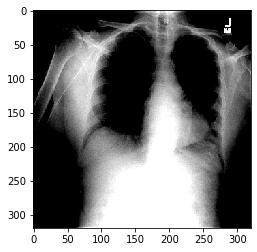

In [13]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='3'></a>
## 3 Model Development

Moving on to model training and development. 

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Plotting the frequency of each of the labels in our dataset:

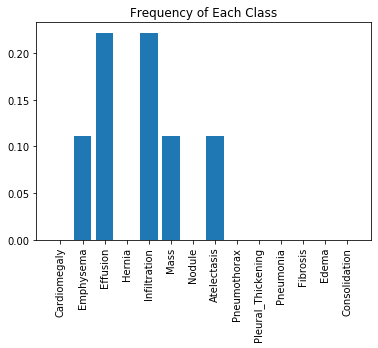

In [14]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, training would take place with an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If a normal cross-entropy loss function were to be used with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

#### Impact of class imbalance on loss function

The overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ is as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

<a name='Ex-2'></a>
### Computing Class Frequencies
Calculating these frequences for each label in the dataset.

In [15]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = (N - np.sum(labels, axis=0)) / N

    return positive_frequencies, negative_frequencies

In [16]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


Computing frequencies for the training data.

In [17]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.        , 0.11111111, 0.22222222, 0.        , 0.22222222,
       0.11111111, 0.        , 0.11111111, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Visualizing these two contribution ratios next to each other for each of the pathologies:

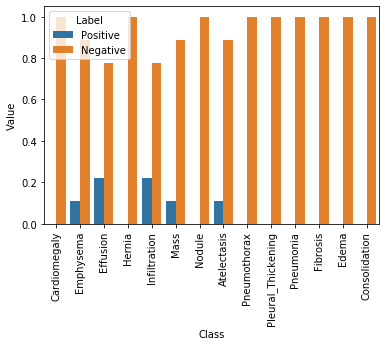

In [18]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, it is desired that the contributions be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this,

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which can be accomplished by  

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, the contribution of positive and negative labels will be balanced.

In [19]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Verifying this by graphing the two contributions next to each other again:

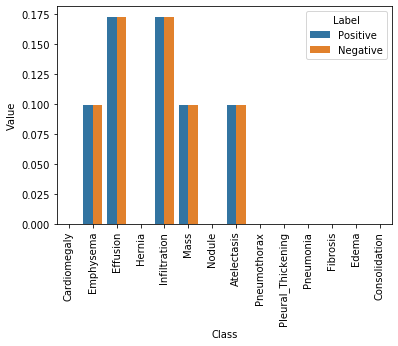

In [20]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function.  

After computing the weights, the final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

<a name='Ex-3'></a>
###  Weighted Loss
Function that returns a loss function that calculates the weighted loss for each batch. 




In [21]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-((pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon))+(neg_weights[i]*(1-y_true[:,i])*K.log(1 - y_pred[:,i]+epsilon)))) #complete this line
        return loss
    
    return weighted_loss

<a name='3-3'></a>
### 3.3 DenseNet121

Next, will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which will be loaded in directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

Will set custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [22]:
# create the base pre-trained model
base_model = DenseNet121(weights='./nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

<a name='4'></a>
## 4 Training




Epoch 1/3
100/100 [==============================] - 630s 6s/step - loss: 0.5744 - val_loss: 17.9090
Epoch 2/3
100/100 [==============================] - 617s 6s/step - loss: 0.4431 - val_loss: 19.7795
Epoch 3/3
100/100 [==============================] - 606s 6s/step - loss: 0.3163 - val_loss: 18.0257


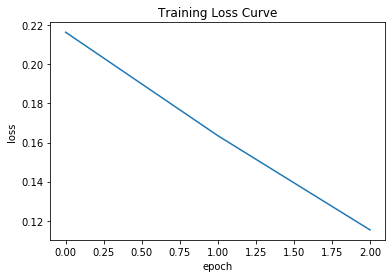

In [29]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

<a name='5'></a>
## 5 Prediction and Evaluation

Now that we have a trained model, time to evaluate it using the test set. 


In [24]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

<a name='5-1'></a>
### 5.1 ROC Curve and AUROC

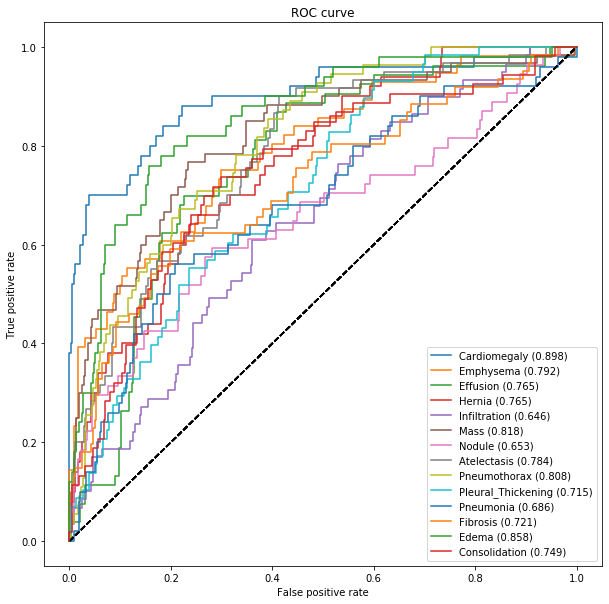

In [33]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

You can compare the performance to the AUCs reported in the original ChexNeXt paper in the table below: 

Here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">


<a name='5-2'></a>
### 5.2 Visualizing Learning with GradCAM 


One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models). 

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM). 
- Class activation maps are useful for understanding where the model is "looking" when classifying an image. 

Will produce a heatmap highlighting the important regions in the image for predicting the pathological condition. 
- This is done by extracting the gradients of each predicted class, flowing into the model's final convolutional layer. 


First, will load a small portion of training set and setup to look at the 4 classes with the highest performing AUC measures.

In [34]:
df = pd.read_csv("nih/train-small.csv")
IMAGE_DIR = "nih/images-small/"

# only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Now let's look at a few specific images.

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


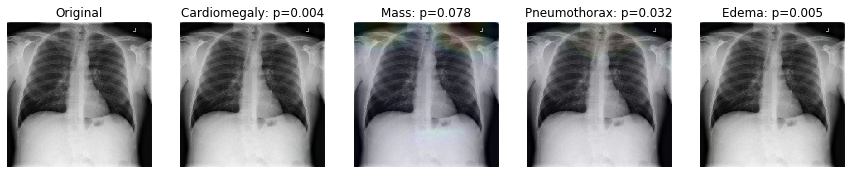

In [35]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


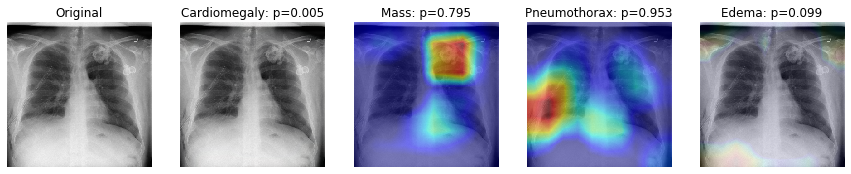

In [36]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


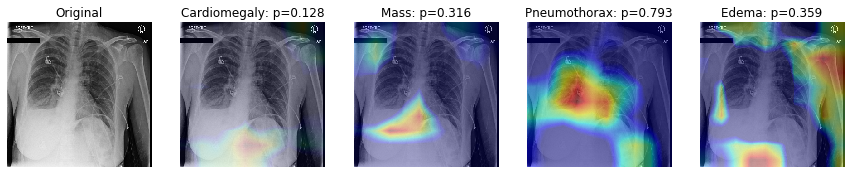

In [37]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


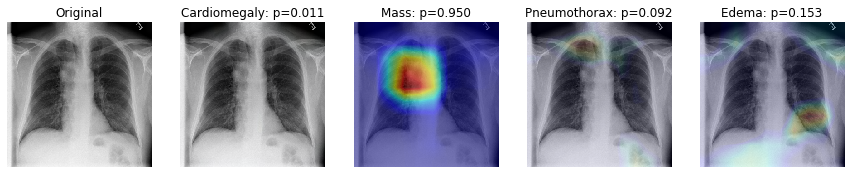

In [38]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)